# Master the Most Hated Task in DS/ML
## Cleaning categorical data with Pandas
<img src='images/mop.jpg'></img>
<figcaption style="text-align: center;">
    <strong>
        Photo by 
        <a href='https://www.pexels.com/@pixabay?utm_content=attributionCopyText&utm_medium=referral&utm_source=pexels'>Pixabay</a>
        on 
        <a href='https://www.pexels.com/photo/brown-wooden-floor-48889/?utm_content=attributionCopyText&utm_medium=referral&utm_source=pexels'>Pexels</a>
    </strong>
</figcaption>

### Introduction

Straight from [Forbes](https://www.forbes.com/sites/gilpress/2016/03/23/data-preparation-most-time-consuming-least-enjoyable-data-science-task-survey-says/#718bbc696f63):
> “Data scientists spend 60% of their time on cleaning and organizing data. Collecting data sets comes second at 19% of their time, meaning data scientists spend around 80% of their time on preparing and managing data for analysis. 57% of data scientists regard cleaning and organizing data as the least enjoyable part of their work and 19% say this about collecting data sets”.

Data cleaning is full of frustration, disgusting surprises that take hours to deal with, always new problems with new datasets, you name it. The process is never enjoyable and always considered as a dirty side of data science. 

Even though it is often hated, it might be the most import step before any data project. Without properly addressing issues with your data, you might compromise all the other stages in the data science workflow.

Without much intro in this second part of my Data Cleaning Series, let's get right to the point. This post is about categorical data cleaning. I will be discussing some common and uncommon methods to deal with some intermediate level categorical data problems. Here is the general overview:

### Setup

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Filter warnings
import warnings
warnings.filterwarnings('ignore')

### Categorical Data, Understanding And Examples

The formal definition of categorical data would be:
> A predefined set of possible categories or groups an observation can fall into.

You can see examples of categorical data in almost all the datasets you have worked on. Nearly any type of data can be turned into categorical. For example:
- Survey responses:
    * `Yes` or `No`
    * `male` or `female`
    * `employed` or `unemployed`
- Numeric data:
    * Annual income in groups: `0-40k`, `40-100k`, ...
    * Ages: child, teenager, adult ...

As we are learning data cleaning using `panads` library, it is important to understand that `pandas` will never import categorical data as categorical. It is mostly imported as strings or integers:

In [2]:
diamonds = pd.read_csv('data/diamonds.csv', index_col=0)
diamonds.dtypes

carat      float64
cut         object
color       object
clarity     object
depth      float64
table      float64
price        int64
x          float64
y          float64
z          float64
dtype: object

You can see that `cut`, `color` and `clarity` are imported as strings rather than as categorical. We could have used the `dtype` parameter of `read_csv` like this:

In [3]:
diamonds = pd.read_csv('data/diamonds.csv',
                       dtype={
                           'cut': 'category',
                           'color': 'category',
                           'clarity': 'category'
                       }, index_col=0)

diamonds.dtypes

carat       float64
cut        category
color      category
clarity    category
depth       float64
table       float64
price         int64
x           float64
y           float64
z           float64
dtype: object

But with real-world datasets, you often do not have this luxury because the data you will be working probably will have many categorical variables and often, you will be completely unfamiliar with the data at first.

Right after you identify the categorical variables, there are some checks and cleaning to be done before you convert the columns to categorical.

### Dealing With Categorical Data Problems

When you work with real-world data, it will be filled with cleaning problems.

As I wrote in the [first part](https://towardsdatascience.com/data-type-constraints-data-range-constraints-duplicate-data-with-pandas-44897a350b1e) of the series, people collecting data won't take into account the cleanliness of the data and do what it takes to record the necessary information in an easy manner as possible. 

Also, problems will arise because of free text during the collection process which leads to typos, many representations of the same value, etc. It is also possible that errors are introduced because of data parsing errors or bad database design.

For example, consider this worst-case scenario: you are working on a survey data conducted across USA and there is a `state` column for the state of each observation in the dataset. There are 50 states in the USA and imagine all the damn variations of state names people can come up with. You are in even bigger problem if data collectors decide to use abbreviations:
- CA, ca, Ca, Caliphornia, Californa, Calfornia, calipornia, CAL, CALI, ...

Such columns will always be filled with typos, errors, inconsistencies. Never imagine that you will have a smooth one-to-one mapping of categories. 

Before moving on to analysis, you have to establish what is called membership constraints which clearly defines the number of categories and how they are represented in a single format.

### Membership Constraints

There are 3 ways you can treat categorical data problems:
- dropping 
- remapping categories
- inferring categories

First, we will focus on isolating inconsistent observations and dropping them. I have created a fake data to illustrate how it is done in code:

In [4]:
# Create possible values for the fake date
first_names = [
    'Lane', 'Ivor', 'Roary', 'Shannon', 'Abdul', 'Mary', 'Cole', 'Desirae'
]

last_names = ['Reese', 'Pierce', 'Gibson', 'Little', 'Fry', 'Colon', 'Palmer']

blood_types = ['O+', 'O-', 'B+', 'B-', 'A+', 'A-', 'AB+', 'AB-', 'C+', 'D-']
probabilites = [0.12, 0.13, 0.13, 0.12, 0.13, 0.12, 0.12, 0.12, 0.005, 0.005]
marriage_status = [
    ' married', 'married', 'unmarried ', 'unmarried', 'MARRIED', 'UNMARRIED',
    'divorced', 'separated'
]
devices = ['iOS', 'AndroidOS', 'MacOS', 'Windows', 'Linux']
size = 10000

dirty_dict = {
    'first_name': np.random.choice(first_names, size),
    'last_name': np.random.choice(last_names, size),
    'blood_type': np.random.choice(blood_types, size, p=probabilites),
    'marriage_status': np.random.choice(marriage_status, size),
    'income': np.random.choice(np.arange(40000, 200000, 15000), size),
    'device': np.random.choice(devices, size)
}

# Data frame from dirty dict with size 10k
sample = pd.DataFrame(dirty_dict)
sample.to_csv('data/demographics.csv', index=False)

In [5]:
demographics = pd.read_csv('data/demographics.csv')
demographics.head(5)

first_name last_name blood_type marriage_status  income     device
0      Abdul     Colon         A+         married  145000  AndroidOS
1      Abdul    Pierce         B+         married   85000      MacOS
2    Desirae    Pierce         B+         MARRIED  130000        iOS
3    Shannon    Gibson         A+         married  175000      MacOS
4    Desirae    Little         B+      unmarried   130000      MacOS

It is often the case that you will have some background information about your data. For example, let's say you want to check for inconsistencies in the `blood_type` column of the above data frame. You find out beforehand that `blood_type`  can only have these categories: **\[A+, A-, B+, B-, O+, O-, AB+, AB-\]**. So, you have to make sure that the column in the data source only includes these values. 

In our case, there are 10k rows and visual search for inconsistencies is not an option, which is also the case for many other real-world data. Here is how can implement the best solution for such problems:

First, you should create a new data frame which holds all the possible values for a categorical column:

In [6]:
categories = pd.DataFrame(
    {'blood_type': ['O+', 'O-', 'B+', 'B-', 'A+', 'A-', 'AB+', 'AB-']})
categories

blood_type
0         O+
1         O-
2         B+
3         B-
4         A+
5         A-
6        AB+
7        AB-

> It is a good practice to create such data frames which hold category mappings for each categorical column in the main data.

As we now have the correct categories in a separate data frame, we can use a basic set operation which gives us the difference of unique values in the two columns:

In [7]:
# Create a set of unique blood types of the main data frame
unique_types_main = set(demographics['blood_type'].unique())
inconsistent_cats = unique_types_main.difference(categories['blood_type'])
inconsistent_cats

{'C+', 'D-'}

To get the difference of two sets, we use `.difference` function. It basically returns all the values from the left set that are not in the right set. Here is a very simple example:

In [8]:
set_1 = {'A', 'B', 'C', 'D'}
set_2 = {'C', 'D', 'E'}
set_1.difference(set_2)

{'A', 'B'}

Attentive readers may have noticed that inside the `set` function, I also called `.unique()` on the `blood_type`. From what I have read from one StackOverflow thread, it seems that the time it takes to get the unique values will be much shorter if you use both `set` and `unique` for larger datasets. 

Now, we will filter our main data for the blood types 'C+' and 'D-':

In [9]:
inconsistent = demographics['blood_type'].isin(inconsistent_cats)
inconsistent

0       False
1       False
2       False
3       False
4       False
        ...  
9995    False
9996    False
9997    False
9998    False
9999    False
Name: blood_type, Length: 10000, dtype: bool

Using `isin` on `blood_type` will return a boolean series which we can use to index the data frame:

In [10]:
inconsistent_rows = demographics[inconsistent]
inconsistent_rows

first_name last_name blood_type marriage_status  income     device
84         Lane    Pierce         C+        divorced   55000        iOS
90         Ivor    Little         C+       separated  175000  AndroidOS
234     Shannon    Palmer         D-        divorced  100000  AndroidOS
458        Cole    Little         D-       UNMARRIED   70000  AndroidOS
480     Shannon    Pierce         D-         married  100000  AndroidOS
...         ...       ...        ...             ...     ...        ...
9246       Ivor    Little         D-        divorced   85000        iOS
9517      Roary    Little         D-         MARRIED  145000      MacOS
9618    Desirae       Fry         C+         MARRIED  115000  AndroidOS
9619    Desirae    Gibson         D-      unmarried   160000      Linux
9912       Ivor    Pierce         D-       separated  160000      Linux

[90 rows x 6 columns]

So, there are 90 individuals with incorrect blood types. Since we don't have any clue of how these errors occurred (I did it😁😁😁), we have to drop them. It can be done in two ways:

In [11]:
# Using drop
demographics = demographics.drop(inconsistent_rows.index)
# Using negative conditioning
demographics = demographics[~inconsistent]
# Check the results
assert set(demographics['blood_type'].unique()) == set(
    categories['blood_type'])

As our column is clean now, it is safe to set it as a categorical variable:

In [12]:
# Set blood_type as a categorical variable
demographics['blood_type'] = demographics['blood_type'].astype('category')
# Check that the results are in effect
assert demographics['blood_type'].dtype == 'category'

> Definitely check out the [first part](https://towardsdatascience.com/data-type-constraints-data-range-constraints-duplicate-data-with-pandas-44897a350b1e) of this series. There, I covered basic and common data problems. You will also familiarize yourself with some of the functions I will be using here.

### Value Inconsistency


Just like we talked in the second section, there may be many representations of the same category in the data set. These errors may occur just because simple typos, random capitalization, you name it. Continuing cleaning our data, the turn has come to the `marriage_status` column:

In [13]:
demographics['marriage_status'].value_counts()

 married      1321
unmarried     1276
UNMARRIED     1253
married       1244
separated     1227
divorced      1223
MARRIED       1210
unmarried     1156
Name: marriage_status, dtype: int64

Using `value_counts` on a data frame column returns the count of unique values in that column. If you look at the result, you can immediately see the issues. The values should be either lower-case or upper-case. I prefer lower-case:

In [14]:
demographics['marriage_status'] = demographics['marriage_status'].str.lower()
demographics['marriage_status'].value_counts()

married       2454
unmarried     2409
 married      1321
unmarried     1276
separated     1227
divorced      1223
Name: marriage_status, dtype: int64

Using `.str` on a data frame column enables us to use all the Python string functions on each value of the column. Here, we are using `.lower()` which converts strings to lowercase.

`value_counts` is still returning 6 unique values, why? After paying close attention, you can see that one of the categories has an extra leading whitespace. That's why it is being treated as an individual category. The same can be true for one of the `unmarried`, it might have a trailing whitespace. We can use the string `strip` function to get rid of trailing whitespace from a string:

In [15]:
demographics['marriage_status'] = demographics['marriage_status'].str.strip()
demographics['marriage_status'].value_counts()

married      3775
unmarried    3685
separated    1227
divorced     1223
Name: marriage_status, dtype: int64

Now the columns is clean. All is left is to convert this column into a category data type too:

In [16]:
# Convert marriage_status to categorical
demographics['marriage_status'] = demographics['marriage_status'].astype(
    'category')
# Check the results
assert demographics['marriage_status'].dtype == 'category'

### Collapsing Data Into Categories

Sometimes, you may want to take already existing data, often numerical, and generate categories from it. This can be useful in a number of cases. 

In our `demographics` dataset, we have an annual income column. It can be useful to cut this column into different income groups because doing so might give some extra insight into the data. 

`pandas` has a perfect function for this: `cut`. It enables us to cut numerical ranges like data frame columns into bins and give them custom labels. Let's see it in action:

In [17]:
ranges = [40000, 75000, 100000, 140000, 170000, np.inf]
labels = ['40k-75k', '75k-100k', '100k-140k', '140k-170k', '170k+']
demographics['income_groups'] = pd.cut(demographics['income'], bins=ranges, labels=labels)
demographics.sample(5)

first_name last_name blood_type marriage_status  income   device  \
4122      Roary     Reese        AB+         married  100000      iOS   
4367    Desirae       Fry        AB+       unmarried   70000    Linux   
8982       Mary    Little        AB-       separated  145000  Windows   
7101       Lane     Colon        AB-       unmarried  130000    MacOS   
7542       Mary    Little         O+       unmarried  175000    Linux   

     income_groups  
4122      75k-100k  
4367       40k-75k  
8982     140k-170k  
7101     100k-140k  
7542         170k+

Now, we can use functions like `value_counts` to get more insight:

In [18]:
demographics['income_groups'].value_counts(sort=False)

40k-75k      1860
75k-100k     1808
100k-140k    1805
140k-170k    1845
170k+        1754
Name: income_groups, dtype: int64

You can also plot a count plot:

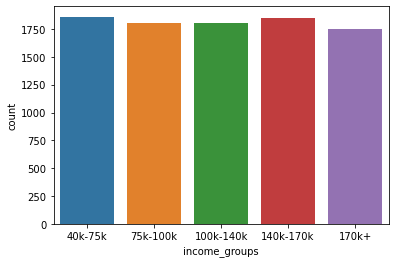

In [24]:
sns.countplot(demographics['income_groups']);

### Reducing the Number of Categories

Sometimes, there may be unnecessary categories. In such cases, you can collapse smaller categories into a general and bigger categories which might suit your needs better. Consider the `device` column of our data:

In [20]:
demographics['device'].value_counts()

MacOS        2029
Windows      2009
iOS          1960
Linux        1959
AndroidOS    1953
Name: device, dtype: int64

It is not much useful to compare a phone operating system to a computer's. What would be better is to reduce the categories into `mobileOS` and `desktopOS`. To do this, first, we need to create a dictionary which maps each category to the new one:

In [21]:
mappings = {
    'Linux': 'desktopOS', 'iOS': 'mobileOS',
    'MacOS': 'desktopOS', 'Windows': 'desktopOS',
    'AndroidOS': 'mobileOS'
}

Then, we use `replace` function of `pandas` which maps out the new categories dynamically:

In [22]:
demographics['device'] = demographics['device'].replace(mappings)
demographics['device'].value_counts()

desktopOS    5997
mobileOS     3913
Name: device, dtype: int64